In [46]:
import json
import csv
import pandas as pd
from pandas import DataFrame, Series
import dateutil.parser
from dateutil.tz import gettz
import datetime
import pytz
from functools import reduce
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import calendar
from time import mktime
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [47]:
# time format conversions

# def roundUnixTime(timestamp):
#     timestamp = timestamp - (timestamp % 3600)
#     return timestamp

def convertUTCToTimestamp(timestamp):
    nanosecondTimestamp = timestamp * 1e9
    timestamp = pd.Timestamp(nanosecondTimestamp, tz='US/Eastern')
    return timestamp

def convertTimeToStruct(timestamp):
    timestamp = time.gmtime(timestamp)
    return timestamp

In [92]:
# mood reporter data

responsesDF = pd.read_csv("../reporter/responses.tsv", sep='\t', header=0, true_values=['true', 'True', 'tru'], false_values=['false', 'False'])

timeValues = responsesDF.unix_time.values

# create DF columns for each unique activity and location entry
activity_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.activity.values)])))))

for activity_name in activity_names:
    responsesDF[activity_name.replace(" ", "_") + "_activity"] = responsesDF.activity.apply(lambda x: activity_name in x.lower())

location_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.location.values)])))))

def split_locations(locations):
    return list(map(lambda x: x.lower().strip(), locations.split(",")))

for location_name in location_names:
    responsesDF[location_name.replace(" ", "_") + "_location"] = responsesDF.location.apply(lambda x: location_name in split_locations(x))

responsesDF.time = responsesDF.unix_time

# delete redundant columns
del responsesDF['moodNotes']
del responsesDF['trigger']
del responsesDF['activity']
del responsesDF['location']
del responsesDF['unix_time']


responsesDF.time = responsesDF.time.apply(convertUTCToTimestamp)

In [49]:
#keylogger data

tone_names = ['Sadness', 'Analytical', 'Joy', 'Fear', 'Tentative', 'Anger', 'Confident']

with open('../keylogger/logs/log_new.json', 'r') as f:
    keyloggerData = json.load(f)

# tzinfos = { "EDT" : gettz("America/New_York") }


# format data
def extract_keyloggerData(data):
    keyloggerResults = []
    keystrokeWordCountResults = []

    for d in data:
        # create columns for each IBM Tone Analyzer sentiment
        keyloggerResult = [0] * (len(tone_names)+1)
        # create columns for my text analysis/keystroke dynamics metrics
        keystrokeWordCountResult = [0] * 6
        
        # add present sentiment scores to keyloggerResult array; absent sentiments remain at 0
        tones = d['document_tone']['tones']
        for i in range(len(tones)):
            score = tones[i]['score']
            tone_name = tones[i]['tone_name']
            tone_index = tone_names.index(tone_name)
            keyloggerResult[tone_index] = score            

        keyloggerResult[-1] = d['unix_time']

        keyloggerResults.append(tuple(keyloggerResult))
        
        # text analysis/keystroke dynamics were added a couple months later
        try:
            keystrokeWordCountResult[0] = d['word_count']
            keystrokeWordCountResult[1] = d['uniqueword_ratio']
            keystrokeWordCountResult[2] = d['backspace_count']
            keystrokeWordCountResult[3] = d['avg_dwelltime']
            keystrokeWordCountResult[4] = d['avg_flighttime']
            keystrokeWordCountResult[5] = d['unix_time']
            
            keystrokeWordCountResults.append(tuple(keystrokeWordCountResult))
            
        except:
            continue
            
    return keyloggerResults, keystrokeWordCountResults

both = extract_keyloggerData(keyloggerData)

# dataframe for IBM Tone Analyzer scores
keyloggerDF = DataFrame(both[0],
                        columns=[tone_name+"_score" for tone_name in tone_names] + ['time'])

# dataframe for text analysis/keystroke dynamics
keystrokeWordCountDF = DataFrame(both[1],
                        columns=['word_count', 'uniqueword_ratio', 'backspace_count', 'avg_dwelltime', 'avg_flighttime', 'time'])

keyloggerDF.time = keyloggerDF.time.apply(convertUTCToTimestamp)
keyloggerDF.sort_values('time', inplace=True)

keystrokeWordCountDF.time = keystrokeWordCountDF.time.apply(convertUTCToTimestamp)
keystrokeWordCountDF.sort_values('time', inplace=True)

In [50]:
#affectiva data


with open('../getAPIdata/merged_file.json', 'r') as f:
    affectivaData = json.load(f)

for x in range(0, len(affectivaData)):
    # convert timestamp to miliseconds
    affectivaData[x]['time'] = affectivaData[x]['time']/ 1e3
    # count number of expressions for each hour
    affectivaData[x]['emoji'] = len(affectivaData[x]['emoji'])


affectivaDF = DataFrame(affectivaData)

# delete redundant columns
del affectivaDF['emotions']
del affectivaDF['max_attention']
del affectivaDF['min_attention']
del affectivaDF['max_engagement']
del affectivaDF['min_engagement']
del affectivaDF['max_valence']
del affectivaDF['min_valence']

affectivaDF.time = affectivaDF.time.apply(convertUTCToTimestamp)
affectivaDF.sort_values('time', inplace=True)

In [51]:
#rescuetime data

from dateutil import parser
import calendar

with open('../getAPIdata/productivity.json', 'r') as f:
    productivityFile = json.load(f)

productivityData = productivityFile['rows']

final_productivityData = [];
UTC = pytz.timezone('UTC')

#convert timestamp string (local time) to structured time object (UTC)
for x in range(0, len(productivityData)):
    date = parser.parse(productivityData[x][0])
    dateutc = str(date.astimezone(UTC))
    dateutc2 = dateutc[:19] + "UTC"
    newtime = time.strptime(dateutc2, "%Y-%m-%d %H:%M:%S%Z")
    finalTime = calendar.timegm(newtime)
    
    # extract productivity score
    prod_score = productivityData[x][4]
    final_productivityData.append((finalTime, prod_score))

productivityDF = DataFrame(final_productivityData, columns=['time', 'productivity_score'])
productivityDF.time = productivityDF.time.apply(convertUTCToTimestamp)

productivityDF.sort_values('time', inplace=True)

In [52]:
#quality time app data

qualityTimeDF = pd.read_csv("../QualityTime/1543959637913_ENTIRE_HISTORY_1480887628603_1543959628603.csv", header=0)
qtTimeVals = qualityTimeDF.End_Time.values

#convert timestamp to miliseconds
newQTtimeVals = []
for x in range(0, len(qtTimeVals)):
    timestamp = time.gmtime(int(qtTimeVals[x]) / 1e3)
    newQTtimeVals.append(timestamp)

# extract time usage data
usageVals = qualityTimeDF.Usage.values
newQTusageVals = []

# if usage data is in hours and/or minutes, convert into seconds
for x in range(0, len(usageVals)):
    string = usageVals[x]
    minSubstring = "min"
    hrSubstring = "hr"
    finalSecs = 0
    
    if hrSubstring in string:
        removeHr = string[0:1]
        newHr = int(removeHr) * 3600
        finalSecs += newHr
    elif minSubstring in string:
        removeMin = string[-6:-4]
        newMin = int(removeMin) * 60
        finalSecs += newMin
    else:
        removeSec = string[0:-4]
        newSec = int(removeSec)
        finalSecs += newSec
        
    newQTusageVals.append(finalSecs)

# sub in new time and usage values
qualityTimeDF.End_Time = newQTtimeVals
qualityTimeDF.Usage = newQTusageVals

# keep only time and usage columns
qualityTimeDF = qualityTimeDF[['End_Time', 'Usage']]
qualityTimeDF.columns = ['time', 'usage_in_sec']

# combine time entries and their usage values into their respective one hour chunks
compressed = []
current_hour = qualityTimeDF['time'][0]
total_usage = 0
unlocks = 0

for index, row in qualityTimeDF.iterrows():
    if (index == len(qualityTimeDF) -1):
        holder = [0] * 3
        holder[0] = current_hour
        holder[1] = unlocks
        holder[2] = total_usage
        compressed.append(tuple(holder))
    elif (row['time'].tm_year == current_hour.tm_year and row['time'].tm_mon == current_hour.tm_mon and row['time'].tm_mday == current_hour.tm_mday and row['time'].tm_hour == current_hour.tm_hour):
        total_usage += row['usage_in_sec']
        unlocks +=1
    else:
        holder = [0] * 3
        holder[0] = current_hour
        holder[1] = unlocks
        holder[2] = total_usage
        compressed.append(tuple(holder))
        total_usage = 0
        unlocks = 0
        current_hour = row['time']
        total_usage += row['usage_in_sec']
        unlocks +=1
        
# new dataframe for compressed data
newQTDF = DataFrame(compressed, columns = ['time', 'phone_unlocks', 'phone_use_secs'])
newQTDF.time = newQTDF.time.apply(mktime)
newQTDF.time = newQTDF.time.apply(convertUTCToTimestamp)

newQTDF.sort_values('time', inplace=True)

In [53]:
# google fit data

with open('../google_fit/dataset.json', 'r') as f:
    fitData = json.load(f)

# combine time entries and their step counts into one hour chunks
stepCountCompressed = []

def extract_fitData(fitData):
    current_timestamp = int(fitData[0]['endTimeNanos']) / 1e9
    current_hour = convertTimeToStruct(int(fitData[0]['endTimeNanos']) / 1e9)
    stepCount = 0

    for d in fitData:
        dHour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
        if (dHour.tm_year == current_hour.tm_year and dHour.tm_mon == current_hour.tm_mon and dHour.tm_mday == current_hour.tm_mday and dHour.tm_hour == current_hour.tm_hour):
            stepCount += int(d['value'][0]['intVal'])
        else:
            holder = [0] * 2
            holder[0] = current_timestamp
            holder[1] = stepCount
            
            stepCountCompressed.append(tuple(holder))
            stepCount = 0

            current_hour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
            current_timestamp = int(d['endTimeNanos']) / 1e9

            stepCount += int(d['value'][0]['intVal'])


extract_fitData(fitData['point'])

stepCountDF = DataFrame(stepCountCompressed, columns = ['time', 'stepCount'])

stepCountDF.time = stepCountDF.time.apply(convertUTCToTimestamp)
stepCountDF.sort_values('time', inplace=True)

In [54]:
#tabcounter data

with open('../getAPIdata/chromeactivity.json', 'r') as f:
    tabCounterData = json.load(f)

newTabData = []

# get values for each key in json, build new dataframe
for key in tabCounterData:
    timestamp = int(key) / 1e3

    current_tabCount = tabCounterData[key]['current_tabCount']
    current_windowCount = tabCounterData[key]['current_windowCount']
    tabs_activated = tabCounterData[key]['tabs_activated']
    tabs_created = tabCounterData[key]['tabs_created']
    windows_created = tabCounterData[key]['windows_created']

    newTabData.append([timestamp, current_tabCount, current_windowCount,tabs_activated,tabs_created,windows_created])

tabColumns = ['time', 'current_tabCount', 'current_windowCount','tabs_activated','tabs_created','windows_created']
tabCounterDF = DataFrame(newTabData, columns=tabColumns)

tabCounterDF.time = tabCounterDF.time.apply(convertUTCToTimestamp)

tabCounterDF.sort_values('time', inplace=True)


In [55]:
# heart rate data

heartRateDF = pd.read_csv("../webcam-pulse-detector-no_openmdao/heartRate.csv", sep=',', header=0)

heartRateDF.time = heartRateDF.time.apply(convertUTCToTimestamp)
heartRateDF.sort_values('time', inplace=True)
heartRateDF = heartRateDF.reset_index(drop=True)

In [56]:
# create dataframe of hour of day (from mood reporter)

def hourOnly(timestamp):
    timestamp = timestamp.hour
    return timestamp


hourColumn = pd.to_datetime(responsesDF.time, unit='s')
hourDF = DataFrame(hourColumn)
hourDF.sort_values('time', inplace=True)
hourDF['hour'] = hourDF.time.apply(hourOnly)

In [93]:
# merge all dataframes on nearest timestamp

mergedDF1 = pd.merge_asof(keyloggerDF, keystrokeWordCountDF, on='time', direction='nearest', tolerance=pd.Timedelta('1 hours')).dropna()
mergedDF1.reset_index(inplace=True)
del mergedDF1['index']

mergedDF2 = pd.merge_asof(affectivaDF, mergedDF1, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF2.reset_index(inplace=True)
del mergedDF2['index']

mergedDF3 = pd.merge_asof(mergedDF2, stepCountDF, on='time', direction='nearest', tolerance=pd.Timedelta('2 hours')).fillna(0)
mergedDF3.reset_index(inplace=True)
del mergedDF3['index']

mergedDF4 = pd.merge_asof(mergedDF3, tabCounterDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF4.reset_index(inplace=True)
del mergedDF4['index']

mergedDF5 = pd.merge_asof(mergedDF4, productivityDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF5.reset_index(inplace=True)
del mergedDF5['index']

mergedDF6 = pd.merge_asof(mergedDF5, newQTDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF6.reset_index(inplace=True)
del mergedDF6['index']

mergedDF7 = pd.merge_asof(mergedDF6, heartRateDF, on='time', direction='nearest', tolerance=pd.Timedelta('2 hours')).dropna()
mergedDF7.reset_index(inplace=True)
del mergedDF7['index']

mergedDF8 = pd.merge_asof(responsesDF, hourDF, on='time', direction='nearest', tolerance=pd.Timedelta('1 hours')).dropna()
mergedDF8.reset_index(inplace=True)
del mergedDF8['index']

finalMergedDF = pd.merge_asof(mergedDF8, mergedDF7, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
finalMergedDF.reset_index(inplace=True)
del finalMergedDF['index']

finalMergedDF

time  mood  unique_interactions  alone  \
0   2018-06-02 19:08:28.065821184-04:00   3.0                    1   True   
1   2018-06-02 20:19:14.888844032-04:00   3.0                    0   True   
2   2018-06-02 21:25:25.471260160-04:00   3.0                    0   True   
3   2018-06-02 22:25:59.244112896-04:00   2.5                    0   True   
4   2018-06-02 23:26:34.387373056-04:00   3.0                    0   True   
5   2018-06-03 15:01:05.512634880-04:00   3.5                    2   True   
6   2018-06-03 16:05:10.222202112-04:00   3.5                    0   True   
7   2018-06-03 17:06:07.752846848-04:00   3.5                    0   True   
8   2018-06-03 21:33:15.274811136-04:00   2.0                    2   True   
9   2018-06-03 22:34:50.265445120-04:00   2.5                    1   True   
10  2018-06-03 23:36:03.059630080-04:00   2.5                    0   True   
11  2018-06-04 13:07:09.689389824-04:00   3.0                    1   True   
12  2018-06-04 14:10:16.359375872-04:00   3.0                    0   True   
13  2018-06-04 15:11:17.590006016-04:00   3.5                    1   True   
14  2018-06-04 16:12:55.318465024-04:00   3.5                    2   True   
15  2018-06-04 17:13:50.572441088-04:00   3.0                    1   True   
16  2018-06-04 20:05:11.112044800-04:00   3.0                    3   True   
17  2018-06-04 21:07:53.273591040-04:00   3.5                    3   True   
18  2018-06-04 22:08:39.701324032-04:00   3.0                    3   True   
19  2018-06-04 23:21:37.555581184-04:00   3.0                    0   True   
20  2018-06-05 00:22:37.274461952-04:00   2.5                    0   True   
21  2018-06-05 01:29:23.293977856-04:00   2.0                    0   True   
22  2018-06-05 16:52:33.391237120-04:00   2.0                    0   True   
23  2018-06-05 17:53:35.761900800-04:00   2.0                    1   True   
24  2018-06-05 19:34:00.970968064-04:00   2.0                    2   True   
25  2018-06-05 20:34:40.677602048-04:00   3.0                    3   True   
26  2018-06-05 21:49:40.132071936-04:00   2.5                    3   True   
27  2018-06-06 13:36:16.182092800-04:00   3.0                    0   True   
28  2018-06-09 00:10:08.384102912-04:00   3.0                    0   True   
29  2018-06-09 14:38:55.257151744-04:00   2.0                    2   True   
..                                  ...   ...                  ...    ...   
683 2018-11-14 22:52:52.188539136-05:00   3.0                    0   True   
684    2018-11-15 01:02:27.024832-05:00   3.0                    0   True   
685    2018-11-15 02:03:16.200416-05:00   3.0                    0   True   
686 2018-11-16 11:47:40.381355008-05:00   3.0                    2   True   
687 2018-11-16 12:51:39.044951040-05:00   3.0                    1   True   
688 2018-11-16 16:10:33.155302144-05:00   4.5                    6  False   
689 2018-11-16 17:58:00.955609088-05:00   4.0                    4  False   
690 2018-11-16 19:33:17.587661056-05:00   3.0                    0   True   
691 2018-11-16 20:34:42.417934848-05:00   3.0                    1   True   
692 2018-12-02 18:27:39.168932864-05:00   2.5                    3   True   
693 2018-12-02 20:14:57.392402944-05:00   3.0                    0   True   
694 2018-12-02 21:43:21.158381824-05:00   3.5                    1   True   
695 2018-12-03 00:16:40.460764160-05:00   3.0                    0   True   
696 2018-12-03 03:03:50.869534976-05:00   2.5                    0   True   
697 2018-12-03 14:22:42.177437952-05:00   3.0                    0   True   
698 2018-12-03 15:29:23.152493056-05:00   2.5                    0   True   
699 2018-12-03 16:34:36.037291008-05:00   2.5                    0   True   
700 2018-12-03 17:44:52.487491072-05:00   2.5                    0   True   
701 2018-12-03 18:48:43.280153088-05:00   3.0                    2   True   
702 2018-12-03 20:19:15.886427904-05:00   3.0                    1   True   
703 2018-12-03 22:35:53.2622768

In [98]:
# del finalMergedDF['time']
# finalMergedDF.to_csv("mergedDF.tsv", sep='\t', encoding='utf-8')

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(finalMergedDF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF.pkl') 

In [95]:
finalMergedDF['alone'] = finalMergedDF['alone'].astype('bool')

finalMergedDF

time  mood  unique_interactions  alone  \
0   2018-06-02 19:08:28.065821184-04:00   3.0                    1   True   
1   2018-06-02 20:19:14.888844032-04:00   3.0                    0   True   
2   2018-06-02 21:25:25.471260160-04:00   3.0                    0   True   
3   2018-06-02 22:25:59.244112896-04:00   2.5                    0   True   
4   2018-06-02 23:26:34.387373056-04:00   3.0                    0   True   
5   2018-06-03 15:01:05.512634880-04:00   3.5                    2   True   
6   2018-06-03 16:05:10.222202112-04:00   3.5                    0   True   
7   2018-06-03 17:06:07.752846848-04:00   3.5                    0   True   
8   2018-06-03 21:33:15.274811136-04:00   2.0                    2   True   
9   2018-06-03 22:34:50.265445120-04:00   2.5                    1   True   
10  2018-06-03 23:36:03.059630080-04:00   2.5                    0   True   
11  2018-06-04 13:07:09.689389824-04:00   3.0                    1   True   
12  2018-06-04 14:10:16.359375872-04:00   3.0                    0   True   
13  2018-06-04 15:11:17.590006016-04:00   3.5                    1   True   
14  2018-06-04 16:12:55.318465024-04:00   3.5                    2   True   
15  2018-06-04 17:13:50.572441088-04:00   3.0                    1   True   
16  2018-06-04 20:05:11.112044800-04:00   3.0                    3   True   
17  2018-06-04 21:07:53.273591040-04:00   3.5                    3   True   
18  2018-06-04 22:08:39.701324032-04:00   3.0                    3   True   
19  2018-06-04 23:21:37.555581184-04:00   3.0                    0   True   
20  2018-06-05 00:22:37.274461952-04:00   2.5                    0   True   
21  2018-06-05 01:29:23.293977856-04:00   2.0                    0   True   
22  2018-06-05 16:52:33.391237120-04:00   2.0                    0   True   
23  2018-06-05 17:53:35.761900800-04:00   2.0                    1   True   
24  2018-06-05 19:34:00.970968064-04:00   2.0                    2   True   
25  2018-06-05 20:34:40.677602048-04:00   3.0                    3   True   
26  2018-06-05 21:49:40.132071936-04:00   2.5                    3   True   
27  2018-06-06 13:36:16.182092800-04:00   3.0                    0   True   
28  2018-06-09 00:10:08.384102912-04:00   3.0                    0   True   
29  2018-06-09 14:38:55.257151744-04:00   2.0                    2   True   
..                                  ...   ...                  ...    ...   
683 2018-11-14 22:52:52.188539136-05:00   3.0                    0   True   
684    2018-11-15 01:02:27.024832-05:00   3.0                    0   True   
685    2018-11-15 02:03:16.200416-05:00   3.0                    0   True   
686 2018-11-16 11:47:40.381355008-05:00   3.0                    2   True   
687 2018-11-16 12:51:39.044951040-05:00   3.0                    1   True   
688 2018-11-16 16:10:33.155302144-05:00   4.5                    6  False   
689 2018-11-16 17:58:00.955609088-05:00   4.0                    4  False   
690 2018-11-16 19:33:17.587661056-05:00   3.0                    0   True   
691 2018-11-16 20:34:42.417934848-05:00   3.0                    1   True   
692 2018-12-02 18:27:39.168932864-05:00   2.5                    3   True   
693 2018-12-02 20:14:57.392402944-05:00   3.0                    0   True   
694 2018-12-02 21:43:21.158381824-05:00   3.5                    1   True   
695 2018-12-03 00:16:40.460764160-05:00   3.0                    0   True   
696 2018-12-03 03:03:50.869534976-05:00   2.5                    0   True   
697 2018-12-03 14:22:42.177437952-05:00   3.0                    0   True   
698 2018-12-03 15:29:23.152493056-05:00   2.5                    0   True   
699 2018-12-03 16:34:36.037291008-05:00   2.5                    0   True   
700 2018-12-03 17:44:52.487491072-05:00   2.5                    0   True   
701 2018-12-03 18:48:43.280153088-05:00   3.0                    2   True   
702 2018-12-03 20:19:15.886427904-05:00   3.0                    1   True   
703 2018-12-03 22:35:53.2622768

In [96]:
corr = finalMergedDF.corr().fillna(0)
corr

mood  unique_interactions     alone  \
mood                          1.000000             0.358236 -0.313695   
unique_interactions           0.358236             1.000000 -0.405078   
alone                        -0.313695            -0.405078  1.000000   
morale                        0.641701             0.194102 -0.218468   
stress                       -0.154322             0.061789 -0.082821   
fatigue                      -0.261635            -0.115869  0.181352   
compulsions                  -0.171356            -0.035288  0.146464   
getting_ready_activity       -0.030056            -0.034860  0.036130   
_activity                     0.000000             0.000000  0.000000   
relaxing_activity             0.000000             0.000000  0.000000   
just_woke_up_activity         0.000000             0.000000  0.000000   
in_class_activity             0.111078             0.171649 -0.436821   
with_k_activity               0.110700            -0.011172 -0.175078   
with_friends_activity         0.454908             0.332465 -0.355930   
chatting_activity             0.141366             0.188990 -0.000464   
emails_activity               0.000000             0.000000  0.000000   
leisure_activity             -0.061335             0.021636  0.156135   
with_parents_activity         0.000000             0.000000  0.000000   
resting_activity              0.019560             0.066996  0.070306   
trying_to_leave_apt_activity  0.000000             0.000000  0.000000   
eating_activity               0.115786             0.052686  0.067188   
therapy_activity             -0.006737             0.009978  0.036130   
working_out_activity         -0.016620             0.036905  0.042264   
feedly_activity              -0.110944            -0.062667  0.138040   
working_activity             -0.057403            -0.001160  0.043166   
mozfest_activity              0.061148             0.049295 -0.055014   
ash_stuff_activity           -0.081146             0.063690  0.074876   
reading_activity             -0.040233            -0.050499  0.021126   
schoolwork_activity           0.068731            -0.080460 -0.055151   
email_activity                0.048327             0.112931  0.063988   
...                                ...                  ...       ...   
london_location              -0.004719             0.030277  0.090416   
library_location             -0.010675            -0.041027 -0.123361   
hour                          0.078293             0.115782 -0.050355   
avg_attention                -0.088177            -0.096603  0.218947   
avg_engagement                0.213672             0.124315 -0.140910   
avg_valence                   0.136866             0.113802 -0.057180   
blinks                        0.048827             0.087481  0.021109   
emoji                         0.205235             0.090373 -0.158564   
Sadness_score                -0.143213            -0.044422  0.033332   
Analytical_score              0.008320             0.003424 -0.053792   
Joy_score                     0.160429             0.100479 -0.047071   
Fear_score                   -0.117004             0.011773  0.083890   
Tentative_score              -0.024376             0.067768  0.070865   
Anger_score                   0.002963             0.087625 -0.017505   
Confident_score              -0.014498            -0.060649  0.015539   
word_count                    0.007880             0.078782 -0.011728   
uniqueword_ratio             -0.030555            -0.043576  0.004989   
backspace_count               0.028994             0.006712 -0.051316   
avg_dwelltime                 0.020564            -0.091724  0.015750   
avg_flighttime               -0.029732            -0.142618  0.014149   
stepCount                     0.111163             0.094667 -0.107026   
current_tabCount              0.097088             0.065483 -0.034602   
current_windowCount           0.097914             0.083405 -0.012526   
tabs_activated     

In [97]:
corr.to_csv("correlationmatrix.tsv", sep='\t', encoding='utf-8')

In [36]:
# create correlation matrix of all variables

import seaborn as sns

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '30px', 'min-width': '60px', 'min-height': '60px', 'max-height': '60px', 'font-size': '8pt', 'padding': '1em 1em'})\
    .set_precision(2)

In [1]:
# get list of variables most and least correlated with mood
corr.mood.sort_values(ascending=False)

NameError: name 'corr' is not defined

In [ ]:
# get list of variables most and least correlated with stress

corr.stress.sort_values(ascending=False)

In [1]:
# corr.blinks.sort_values(ascending=False)

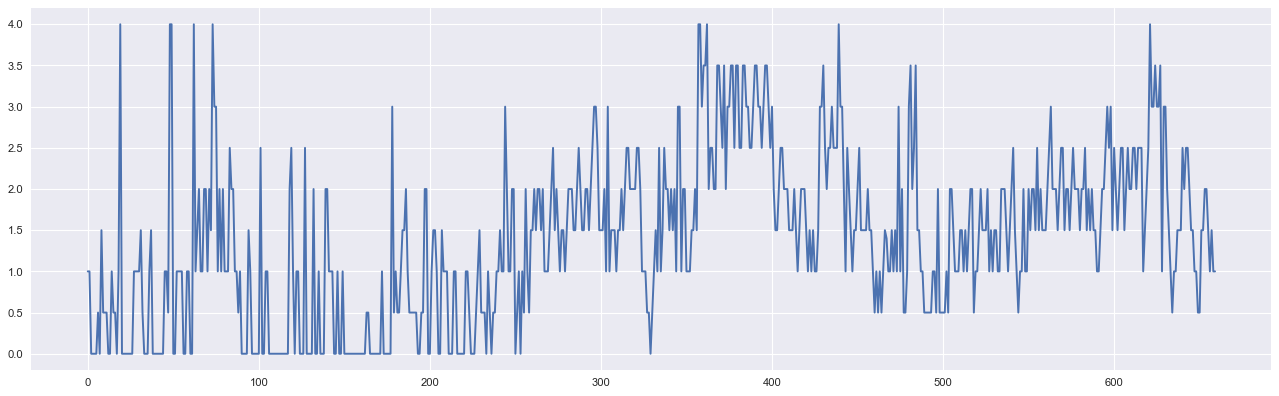

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(finalMergedDF["stress"])
plt.show()